Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [5]:
words[5600]

'so'

Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
#         index = 0
      index = dictionary[word]
    else:
#       index = dictionary[word]
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5243, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [11]:
del words  # Hint to reduce memory.

Function to generate a training batch for the skip-gram model.

In [47]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)


  for i in range(batch_size // num_skips):
#     print('i:', i,
#           'buffer:', [reverse_dictionary[x] for x in buffer], 
#           'data index:', data_index,
#           'skip_window:', skip_window)
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
#       print('\tj:', j, 'targets_to_avoid:', targets_to_avoid, 'span-1:', span)
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
#       print('\t\t', i * num_skips + j, '>>',
#             'skip_window:', skip_window,
#             'target:', target)
#       print('\t\t', '  >>',
#             'batch: ', reverse_dictionary[buffer[skip_window]],
#             'target:', reverse_dictionary[buffer[target]])
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

bs = 24
print('data:', [reverse_dictionary[di] for di in data[:bs]])

for num_skips, skip_window in [(2, 1), (2, 3)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=bs, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(bs)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used', 'against', 'against', 'early', 'early', 'working', 'working', 'class', 'class']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a', 'term', 'abuse', 'of', 'first', 'abuse', 'used', 'first', 'against', 'early', 'used', 'against', 'working', 'class', 'early', 'radicals', 'working']

with num_skips = 2 and skip_window = 3:
    batch: ['a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used', 'against', 'against', 'early', 'early', 'working', 'working', 'class', 'class', 'radicals', 'radicals', 'including', 'including']
    labels:

Train a skip-gram model.

In [48]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [49]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.105362
Nearest to also: terminator, needles, minced, origination, graft, ilp, definitive, diving,
Nearest to see: encased, patmos, firmware, goat, circumscription, electrolytic, forerunners, offers,
Nearest to is: butcher, pbk, modernized, start, livre, octavio, plexus, lacanian,
Nearest to during: height, handedness, formants, cartoonist, bi, civilised, slopes, cfr,
Nearest to new: flanagan, verbal, redistribution, casualties, diameters, erotic, synthesis, dodecanese,
Nearest to united: mitigate, bits, leg, crypt, borders, famous, desks, captain,
Nearest to of: reconstructed, marlene, acta, codebase, cabral, ejaculate, guericke, carbon,
Nearest to no: berio, negative, hyacinthus, doodle, ominous, epiphenomenalism, simile, aol,
Nearest to d: greens, epiphany, crone, recapture, on, protocol, grateful, ovation,
Nearest to some: centrale, warner, whose, guaranteeing, cavan, duma, ancona, pvt,
Nearest to people: rewarded, quadratic, psyche, punish, aut

Average loss at step 52000: 3.437508
Average loss at step 54000: 3.431597
Average loss at step 56000: 3.440783
Average loss at step 58000: 3.394169
Average loss at step 60000: 3.389907
Nearest to also: often, now, still, usually, sometimes, generally, there, never,
Nearest to see: references, according, include, but, includes, list, can, bot,
Nearest to is: was, are, has, be, becomes, although, employ, does,
Nearest to during: after, in, before, when, although, at, throughout, from,
Nearest to new: special, greyface, erotic, grt, manfred, octahedral, malta, previous,
Nearest to united: desks, borders, nightmares, bittersweet, corrode, ageing, lafcadio, leg,
Nearest to of: in, for, evangelica, from, like, enduring, cooperating, same,
Nearest to no: any, aol, ominous, brahmagupta, silhouette, a, cleese, little,
Nearest to d: b, f, h, w, e, eavesdropping, m, r,
Nearest to some: many, several, these, any, all, most, their, certain,
Nearest to people: individuals, women, members, scholars, 

In [50]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

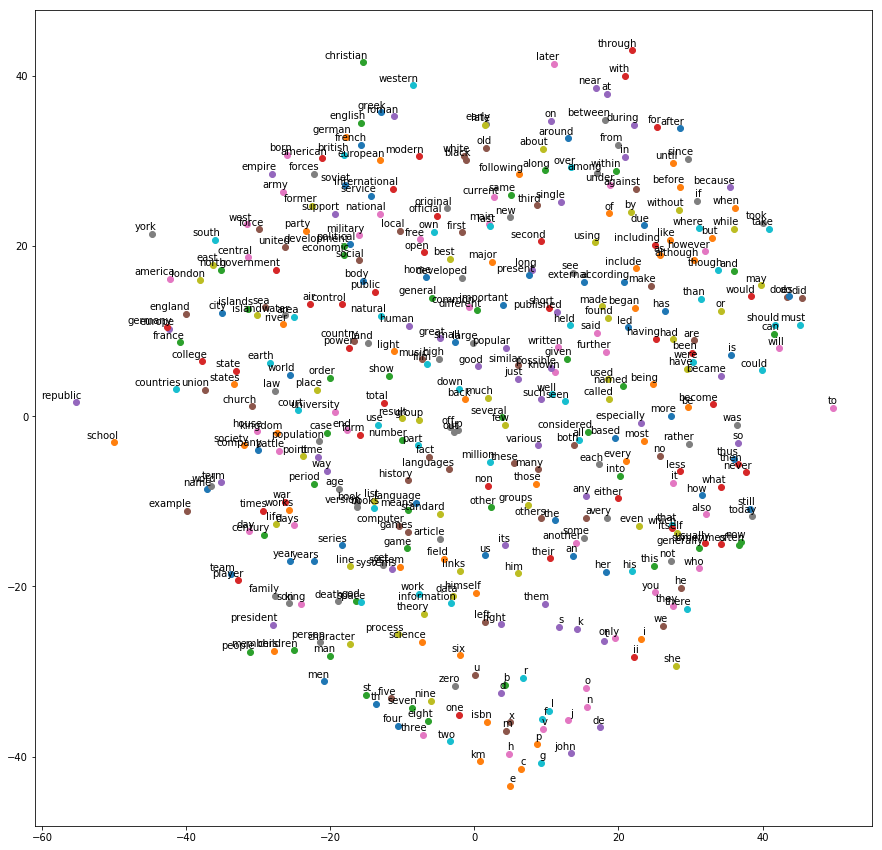

In [51]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [1]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 41, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
